In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import yfinance as yf

# Load training and testing data using yfinance
train_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
test_data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')

# Define the environment
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.action_space = gym.spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_owned = 0
        self.trades = []  # List to track trades
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data['Close'].iloc[self.current_step]])

    def step(self, action):
        current_price = self.data['Close'].iloc[self.current_step]
        
        # Implement action
        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            if shares_to_buy > 0:  # Check if can buy
                self.balance -= shares_to_buy * current_price
                self.shares_owned += shares_to_buy
                self.trades.append((self.current_step, 'Buy', shares_to_buy, current_price))
        elif action == 2:  # Sell
            if self.shares_owned > 0:  # Check if can sell
                self.balance += self.shares_owned * current_price
                self.trades.append((self.current_step, 'Sell', self.shares_owned, current_price))
                self.shares_owned = 0
        
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        
        reward = self.balance + (self.shares_owned * current_price) - self.initial_balance
        return self._next_observation(), reward, done, {}

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = self._build_model(action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def _build_model(self, action_size):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(torch.tensor(state, dtype=torch.float32))
        return np.argmax(act_values.detach().numpy())  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model(torch.tensor(next_state, dtype=torch.float32)).detach().numpy())
            
            target_f = self.model(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            target_f[0][action] = target
            
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(torch.tensor(target_f, dtype=torch.float32), self.model(torch.tensor(state, dtype=torch.float32)))
            loss.backward()
            self.optimizer.step()

    def save_model(self, file_name):
        torch.save(self.model.state_dict(), file_name)
        print(f"Model saved to {file_name}")

    def load_model(self, file_name):
        self.model.load_state_dict(torch.load(file_name))
        self.model.eval()
        print(f"Model loaded from {file_name}")

# Initialize environment and agent with training data
env = StockTradingEnv(train_data)
agent = DQNAgent(state_size=1, action_size=env.action_space.n)

# Training loop
num_episodes = 50
for e in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, 1])
    for time in range(len(train_data) - 1):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 1])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e + 1}/{num_episodes}, Score: {reward}")
            break
        if len(agent.memory) > 32:
            agent.replay(32)

# Save the trained model
agent.save_model('dqn_stock_trading_model.pth')

# Load the model for testing
agent.load_model('dqn_stock_trading_model.pth')

# Testing the trained agent with testing data
test_env = StockTradingEnv(test_data)
test_state = test_env.reset()
test_state = np.reshape(test_state, [1, 1])
test_trades = []

for time in range(len(test_data) - 1):
    action = agent.act(test_state)
    next_state, reward, done, _ = test_env.step(action)
    next_state = np.reshape(next_state, [1, 1])
    test_trades.extend(test_env.trades)
    test_state = next_state
    if done:
        break

# Plotting trades and evaluation metrics
plt.figure(figsize=(14, 7))
plt.plot(test_data['Close'], label='Stock Price', color='blue')

# Plot trades
for trade in test_trades:
    plt.annotate(trade[1], xy=(trade[0], trade[3]), xytext=(trade[0], trade[3] + 1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )
plt.title('Stock Price and Trades')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print evaluation metrics
final_balance = test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[-1])
print(f"Final Balance: {final_balance:.2f}")
print(f"Total Returns: {((final_balance - test_env.initial_balance) / test_env.initial_balance) * 100:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
env = StockTradingEnv(train_data)
agent = DQNAgent(state_size=1, action_size=env.action_space.n)

# Training loop
num_episodes = 50
for e in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, 1])
    for time in range(len(train_data) - 1):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 1])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e + 1}/{num_episodes}, Score: {reward}")
            break
        if len(agent.memory) > 32:
            agent.replay(32)
# Save the trained model
agent.save_model('dqn_stock_trading_model50.pth')

Episode: 1/50, Score: -1025.2120933532715
Episode: 2/50, Score: -1799.1656875610352
Episode: 3/50, Score: 4495.74955368042
Episode: 4/50, Score: 452.2620658874512
Episode: 5/50, Score: 5330.124240875244
Episode: 6/50, Score: -168.94359588623047
Episode: 7/50, Score: 10210.732807159424
Episode: 8/50, Score: 639.207836151123
Episode: 9/50, Score: 1189.659755706787
Episode: 10/50, Score: 341.01948165893555
Episode: 11/50, Score: 11746.594596862793
Episode: 12/50, Score: 565.966251373291
Episode: 13/50, Score: -533.9946746826172
Episode: 14/50, Score: -37.9361572265625
Episode: 15/50, Score: 4553.86901473999
Episode: 16/50, Score: 4565.581520080566
Episode: 17/50, Score: 2103.034191131592
Episode: 18/50, Score: 2563.5167236328125
Episode: 19/50, Score: 1033.099723815918
Episode: 20/50, Score: 2288.9731369018555
Episode: 21/50, Score: 11770.376277923584
Episode: 22/50, Score: 5349.323101043701
Episode: 23/50, Score: 10220.058052062988
Episode: 24/50, Score: 9054.452278137207
Episode: 25/50,

In [4]:
# Save the model
torch.save({
    'model_state_dict': agent.model.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'memory': agent.memory,  # Optionally save memory if you want to continue training
}, 'dqn_stock_trading_model50.pth')

C:\Users\mnoch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


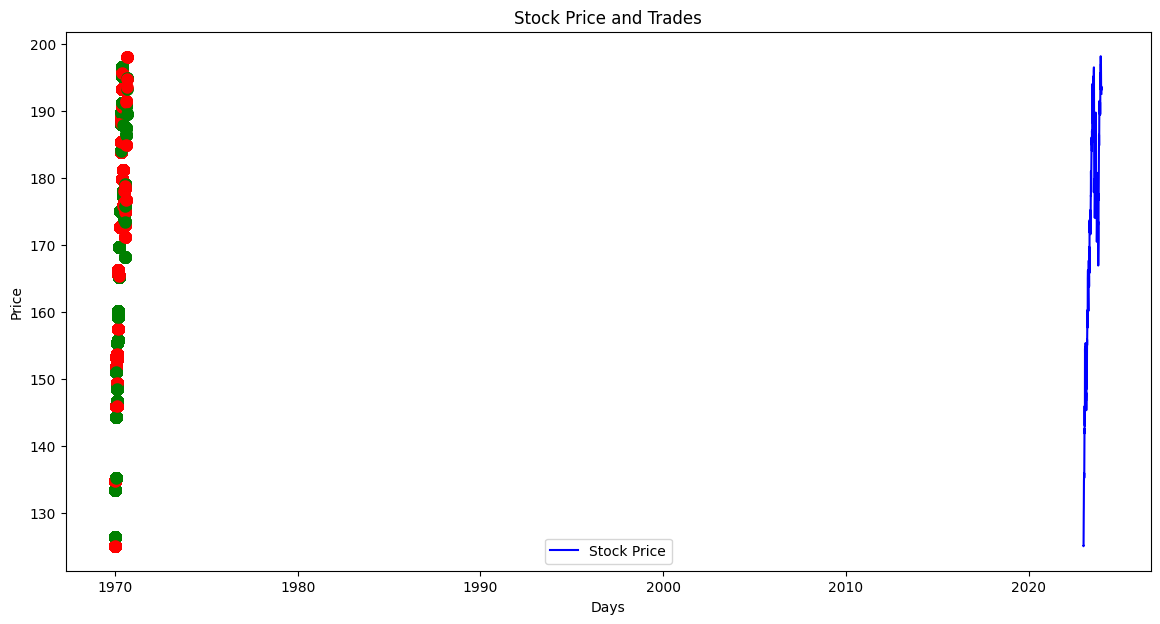

Final Balance: 13566.61
Total Returns: 35.67%


In [5]:
# Testing the trained agent with testing data
test_env = StockTradingEnv(test_data)
test_state = test_env.reset()
test_state = np.reshape(test_state, [1, 1])
test_trades = []

for time in range(len(test_data) - 1):
    action = agent.act(test_state)
    next_state, reward, done, _ = test_env.step(action)
    next_state = np.reshape(next_state, [1, 1])
    test_trades.extend(test_env.trades)
    test_state = next_state
    if done:
        break

# Plotting trades and evaluation metrics
plt.figure(figsize=(14, 7))
plt.plot(test_data['Close'], label='Stock Price', color='blue')

# Plot trades
for trade in test_trades:
    color = 'green' if trade[1] == 'Buy' else 'red'  # Green for Buy, Red for Sell
    plt.plot(trade[0], trade[3], marker='o', color=color, markersize=8)  # Add markers at trade points

plt.title('Stock Price and Trades')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print evaluation metrics
final_balance = test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[-1])
print(f"Final Balance: {final_balance:.2f}")
print(f"Total Returns: {((final_balance - test_env.initial_balance) / test_env.initial_balance) * 100:.2f}%")

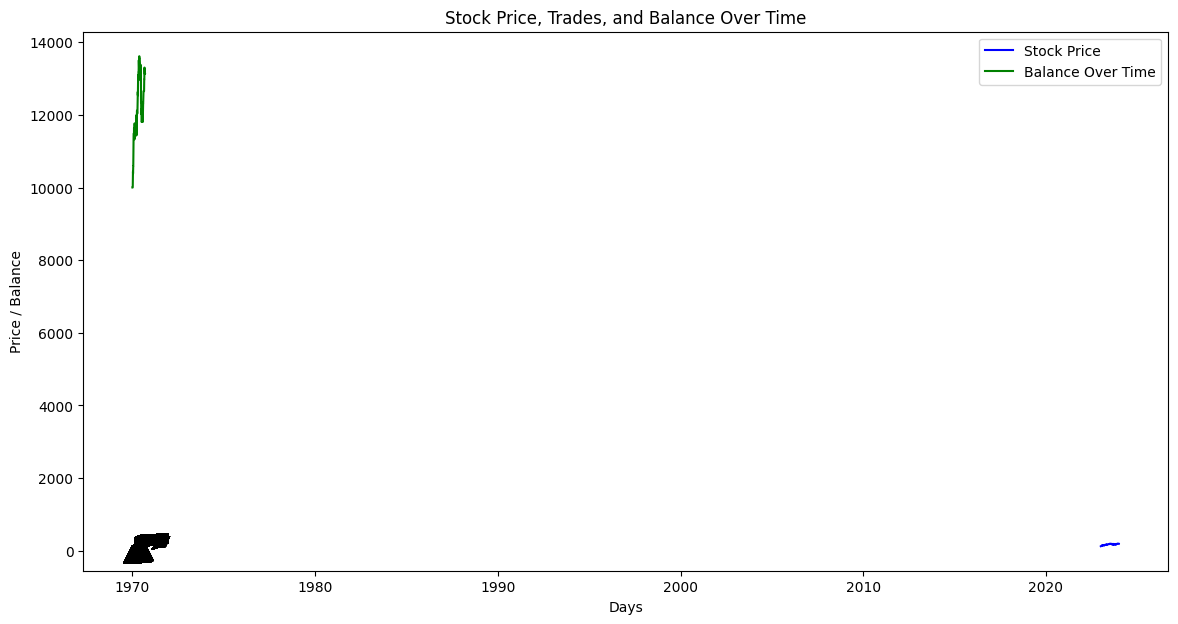

Final Balance: 13131.44
Total Returns: 31.31%
Max Drawdown: 13.29%
Sharpe Ratio: 0.12
Profit-Loss Ratio: 2.37


In [6]:
import numpy as np

# Testing the trained agent
test_env = StockTradingEnv(test_data)
test_state = test_env.reset()
test_state = np.reshape(test_state, [1, 1])
test_trades = []
balance_over_time = [test_env.initial_balance]

for time in range(len(test_data) - 1):
    action = agent.act(test_state)
    next_state, reward, done, _ = test_env.step(action)
    next_state = np.reshape(next_state, [1, 1])
    test_trades.extend(test_env.trades)  # Record trades
    balance_over_time.append(test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[time]))
    test_state = next_state
    if done:
        break

# Final balance after testing
final_balance = test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[-1])
total_returns = ((final_balance - test_env.initial_balance) / test_env.initial_balance) * 100

# Calculate Max Drawdown
peak_balance = balance_over_time[0]
max_drawdown = 0
for balance in balance_over_time:
    peak_balance = max(peak_balance, balance)
    drawdown = (peak_balance - balance) / peak_balance
    max_drawdown = max(max_drawdown, drawdown)
max_drawdown_percent = max_drawdown * 100

# Calculate Sharpe Ratio
returns = np.diff(balance_over_time) / balance_over_time[:-1]  # Daily returns
average_return = np.mean(returns)
std_dev_return = np.std(returns)
risk_free_rate = 0  # Set to 0 for simplicity; adjust as necessary
sharpe_ratio = (average_return - risk_free_rate) / std_dev_return if std_dev_return != 0 else 0


# Calculate Profit-Loss Ratio
profits = []
losses = []
for trade in test_trades:
    if trade[1] == 'Sell':
        pnl = trade[2] * (trade[3] - test_env.data['Close'].iloc[trade[0] - 1])  # Profit or loss
        if pnl > 0:
            profits.append(pnl)
        elif pnl < 0:
            losses.append(abs(pnl))

profit_loss_ratio = (np.mean(profits) / np.mean(losses)) if losses else np.inf  # Avoid division by zero

# Plotting trades and balance over time
plt.figure(figsize=(14, 7))
plt.plot(test_data['Close'], label='Stock Price', color='blue')
plt.plot(balance_over_time, label='Balance Over Time', color='green')

# Plot trades
for trade in test_trades:
    plt.annotate(trade[1], xy=(trade[0], trade[3]), xytext=(trade[0], trade[3] + 1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 )
plt.title('Stock Price, Trades, and Balance Over Time')
plt.xlabel('Days')
plt.ylabel('Price / Balance')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"Final Balance: {final_balance:.2f}")
print(f"Total Returns: {total_returns:.2f}%")
print(f"Max Drawdown: {max_drawdown_percent:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Profit-Loss Ratio: {profit_loss_ratio:.2f}")


# Loading the Trained Model and simulating trades #

In [1]:
import yfinance as yf

train_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
test_data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.action_space = gym.spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_owned = 0
        self.trades = []
        return self._next_observation()

    def _next_observation(self):
        return np.array([self.data['Close'].iloc[self.current_step]])

    def step(self, action):
        current_price = self.data['Close'].iloc[self.current_step]
        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            if shares_to_buy > 0:
                self.balance -= shares_to_buy * current_price
                self.shares_owned += shares_to_buy
                self.trades.append((self.current_step, 'Buy', shares_to_buy, current_price))
        elif action == 2:  # Sell
            if self.shares_owned > 0:
                self.balance += self.shares_owned * current_price
                self.trades.append((self.current_step, 'Sell', self.shares_owned, current_price))
                self.shares_owned = 0
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        reward = self.balance + (self.shares_owned * current_price) - self.initial_balance
        return self._next_observation(), reward, done, {}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = self._build_model(action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def _build_model(self, action_size):
        model = nn.Sequential(
            nn.Linear(self.state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(torch.tensor(state, dtype=torch.float32))
        return np.argmax(act_values.detach().numpy())  # returns action

env = StockTradingEnv(train_data)
agent = DQNAgent(state_size=1, action_size=env.action_space.n)

In [3]:
# Load the saved model
checkpoint = torch.load('dqn_stock_trading_model50.pth')
agent.model.load_state_dict(checkpoint['model_state_dict'])
agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
agent.epsilon = checkpoint['epsilon']
agent.memory = checkpoint['memory']  # If continuing training, load memory
agent.model.eval()  # Set to evaluation mode

# Testing the trained agent with testing data
test_env = StockTradingEnv(test_data)
test_state = test_env.reset()
test_state = np.reshape(test_state, [1, 1])
test_trades = []

# Track rewards, balances, and portfolio values for metrics
portfolio_values = [test_env.initial_balance]

for time in range(len(test_data) - 1):
    action = agent.act(test_state)
    next_state, reward, done, _ = test_env.step(action)
    next_state = np.reshape(next_state, [1, 1])
    test_trades.extend(test_env.trades)
    portfolio_values.append(test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[time]))
    test_state = next_state
    if done:
        break

# Calculate Evaluation Metrics
final_balance = test_env.balance + (test_env.shares_owned * test_env.data['Close'].iloc[-1])
total_returns = ((final_balance - test_env.initial_balance) / test_env.initial_balance) * 100
daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]  # Daily returns for Sharpe Ratio
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) if np.std(daily_returns) != 0 else 0

print(f"Final Balance: {final_balance:.2f}")
print(f"Total Returns: {total_returns:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Final Balance: 13321.09
Total Returns: 33.21%
Sharpe Ratio: 0.15


C:\Users\mnoch\AppData\Local\Temp\ipykernel_65800\401490398.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('dqn_stock_trading_model50.pth')


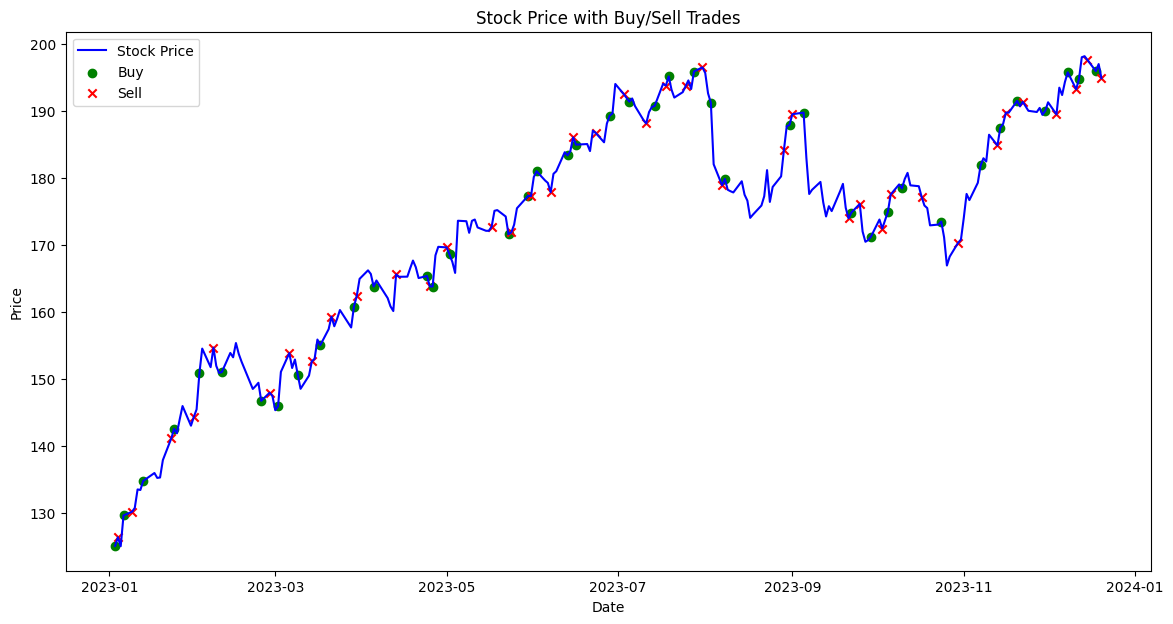

In [28]:
# Ensure correct date range for plotting
if test_env.trades:
    # Determine the range of dates based on the trades
    first_trade_day = test_env.trades[0][0]
    last_trade_day = test_env.trades[-1][0]
    # Slice data to only show the trading period
    plot_data = test_data['Close'].iloc[first_trade_day:last_trade_day + 1]
else:
    plot_data = test_data['Close']  # Default to full data if no trades

# Convert index to datetime for accurate plotting
plot_data.index = pd.to_datetime(plot_data.index)

# Plot stock prices within the trade date range
plt.figure(figsize=(14, 7))
plt.plot(plot_data.index, plot_data.values, label='Stock Price', color='blue')

# Flags to control legend entries for Buy and Sell markers
buy_plotted = False
sell_plotted = False

# Plot each trade with markers
for trade in test_env.trades:
    day, action, _, price = trade
    date = plot_data.index[day]  # Get the date of the trade
    color = 'green' if action == 'Buy' else 'red'
    
    # Only add label once for each type of trade
    if action == 'Buy' and not buy_plotted:
        plt.scatter(date, price, color=color, label='Buy', marker='o')
        buy_plotted = True
    elif action == 'Sell' and not sell_plotted:
        plt.scatter(date, price, color=color, label='Sell', marker='x')
        sell_plotted = True
    else:
        plt.scatter(date, price, color=color, marker='o' if action == 'Buy' else 'x')

# Title and labels
plt.title('Stock Price with Buy/Sell Trades')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()
